# Project: Exploration Image Classification in Python and ArcGIS (Python version)
Date: 8th April 2022
Name: Yue Zhao


#### 1 Load packages

In [1]:
# import required package
from osgeo import gdal
import gdal
import osgeo
import rasterio
import matplotlib.pyplot as plt
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from osgeo import ogr
from sklearn.ensemble import RandomForestClassifier

#### 2 Take a look at the satellite images

In [2]:
# Get the path of tiff images path
stack_out_path = r'C:\Users\zhaoy6429\Documents\ESRI exploration\02Data\processed\landsat_stack.gtif'
file_list = glob.glob(r'C:\Users\zhaoy6429\Documents\ESRI exploration\04ArcGISProject\Landsat9ImageClaasification\*.tif')
array, raster_prof = es.stack(file_list, out_path=stack_out_path)

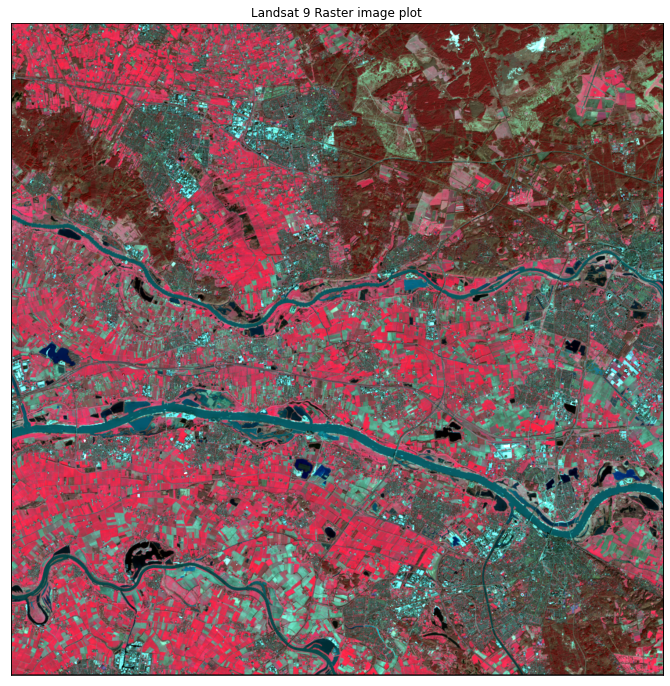

In [3]:
fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(
    array,
    rgb=(4,3,2),
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="Landsat 9 Raster image plot",
)
plt.show()

#### 3 Read training samples

In [4]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [5]:
# Open the dataset from the file
traning_data = ogr.Open(r'C:\Users\zhaoy6429\Documents\ESRI exploration\02Data\processed\Traning_set.shp')

if not traning_data:
    print('Error: could not open dataset')

#### 4 training sample description

In [6]:
### Let's get the driver from this file
driver = traning_data.GetDriver()
print('Dataset driver is: {n}\n'.format(n=driver.name))

### How many layers are contained in this Shapefile?
layer_count = traning_data.GetLayerCount()
print('The shapefile has {n} layer(s)\n'.format(n=layer_count))

### What is the name of the 1 layer?
layer = traning_data.GetLayerByIndex(0)
print('The layer is named: {n}\n'.format(n=layer.GetName()))

### What is the layer's geometry? is it a point? a polyline? a polygon?
# First read in the geometry - but this is the enumerated type's value
geometry = layer.GetGeomType()

# So we need to translate it to the name of the enum
geometry_name = ogr.GeometryTypeToName(geometry)
print("The layer's geometry is: {geom}\n".format(geom=geometry_name))

### What is the layer's projection?
# Get the spatial reference
spatial_ref = layer.GetSpatialRef()

# Export this spatial reference to something we can read... like the Proj4
proj4 = spatial_ref.ExportToProj4()
print('Layer projection is: {proj4}\n'.format(proj4=proj4))

### How many features are in the layer?
feature_count = layer.GetFeatureCount()
print('Layer has {n} features\n'.format(n=feature_count))

### How many fields are in the shapefile, and what are their names?
# First we need to capture the layer definition
defn = layer.GetLayerDefn()

# The amount of field
field_count = defn.GetFieldCount()
print('Layer has {n} fields'.format(n=field_count))

# Field name
print('Their names are: ')
for i in range(field_count):
    field_defn = defn.GetFieldDefn(i)
    print('\t{name} - {datatype}'.format(name=field_defn.GetName(),
                                         datatype=field_defn.GetTypeName()))


Dataset driver is: ESRI Shapefile

The shapefile has 1 layer(s)

The layer is named: Traning_set

The layer's geometry is: 3D Polygon

Layer projection is: +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

Layer has 253 features

Layer has 7 fields
Their names are: 
	Classcode - String
	Classname - String
	Classvalue - Integer64
	RED - Integer64
	GREEN - Integer64
	BLUE - Integer64
	Count - Integer64


#### 5 Rasterize vector layer

In [7]:
# Open raster image
landsat = gdal.Open(r'C:\Users\zhaoy6429\Documents\ESRI exploration\04ArcGISProject\Landsat9ImageClaasification\LC09_band1.tif', gdal.GA_ReadOnly)

In [8]:
# Fetch number of rows and columns
ncol = landsat.RasterXSize
nrow = landsat.RasterYSize

# Fetch projection and extent
proj = landsat.GetProjectionRef()
ext = landsat.GetGeoTransform()

raster_ds = None

# Create the raster dataset
memory_driver = gdal.GetDriverByName('GTiff')
out_raster_ds = memory_driver.Create(r'C:\Users\zhaoy6429\Documents\ESRI exploration\02Data\processed\training_data.gtif', ncol, nrow, 1, gdal.GDT_Byte)

# Set the ROI image's projection and extent to our input raster's projection and extent
out_raster_ds.SetProjection(proj)
out_raster_ds.SetGeoTransform(ext)

# Fill our output band with the 0 blank, no class label, value
b = out_raster_ds.GetRasterBand(1)
b.Fill(0)

# Rasterize the shapefile layer to our new dataset
status = gdal.RasterizeLayer(out_raster_ds,  # output to our new dataset
                             [1],  # output to our new dataset's first band
                             layer,  # rasterize this layer
                             None, None,  # don't worry about transformations since we're in same projection
                             [0],  # burn value 0
                             ['ALL_TOUCHED=TRUE',  # rasterize all pixels touched by polygons
                              'ATTRIBUTE=Classvalue']  # put raster values according to the 'id' field values
                             )

# Close dataset
out_raster_ds = None

if status != 0:
    print("I don't think it worked...")
else:
    print("Success")

Success


#### Check rasterized layer

In [9]:
training_raster = gdal.Open(r'C:\Users\zhaoy6429\Documents\ESRI exploration\02Data\processed\training_data.gtif')
training_r = training_raster.GetRasterBand(1).ReadAsArray()

# How many pixels are in each class?
classes = np.unique(training_r)
# Iterate over all class labels in the ROI image, printing out some information
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(training_r == c).sum()))

Class 0 contains 1239578 pixels
Class 10 contains 2095 pixels
Class 20 contains 9491 pixels
Class 40 contains 7414 pixels
Class 80 contains 7047 pixels


#### Process Landsat 9 and training set at the same time

In [10]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read Landsat9 image and training image
img_ds = gdal.Open(r'C:\Users\zhaoy6429\Documents\ESRI exploration\02Data\processed\landsat_stack.gtif', gdal.GA_ReadOnly)
roi_ds = gdal.Open(r'C:\Users\zhaoy6429\Documents\ESRI exploration\02Data\processed\training_data.gtif', gdal.GA_ReadOnly)

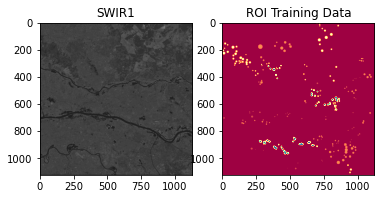

In [11]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               osgeo.gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 5], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

#### Pairing Y with X

Now that we have the image we want to classify (our X feature inputs), and the ROI with the land cover labels (our Y labeled data), we need to pair them up in NumPy arrays so we may feed them to Random Forest:

In [12]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# 10 - Water
# 20 - Buildup Area
# 40 - Forest
# 80 - Planted / Cultivated

We have 26047 samples
The training data include 4 classes: [10 20 40 80]


In [13]:
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))


Our X matrix is sized: (26047, 8)
Our y array is sized: (26047,)


#### Train with Random Forest

In [14]:
# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [15]:
# With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 98.32994202787269%


In [16]:
bands = [1, 2, 3, 4, 5, 6, 7, 8]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.043035013385402075
Band 2 importance: 0.11140260636653823
Band 3 importance: 0.18602297887490554
Band 4 importance: 0.10554927071211784
Band 5 importance: 0.22729883373316564
Band 6 importance: 0.12232049504583228
Band 7 importance: 0.15946223821984476
Band 8 importance: 0.04490856366219379


#### Confusion Matrix

In [19]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict    10    20    40    80    All
truth                                 
10       2095     0     0     0   2095
20          0  9491     0     0   9491
40          0     0  7414     0   7414
80          0     0     0  7047   7047
All      2095  9491  7414  7047  26047


 I highly doubt the real confusion matrix will be 100% accuracy. What is likely going on is that we used a large number of trees within a machine learning algorithm to best figure out the pattern in our training data. Given enough information and effort, this algorithm precisely learned what we gave it. Asking to validate a machine learning algorithm on the training data is a useless exercise that will overinflate the accuracy.

Instead, we could have done a crossvalidation approach where we train on a subset the dataset, and then predict and assess the accuracy using the sections we didn't train it on. To get a robust measure of the performance, we would run this using random subsets some number of times.

#### Predict the rest of the image

In [17]:
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

Reshaped from (1125, 1125, 8) to (1265625, 8)


In [18]:
# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

In [19]:
# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape);class_prediction

array([[10, 10, 10, ..., 10, 10, 10],
       [10, 20, 20, ..., 20, 20, 10],
       [10, 20, 20, ..., 40, 40, 10],
       ...,
       [10, 80, 80, ..., 80, 80, 10],
       [10, 80, 80, ..., 80, 80, 10],
       [10, 10, 10, ..., 10, 10, 10]], dtype=uint8)

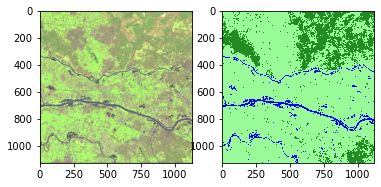

In [21]:
# Visualize

# First setup a 6-5-4 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img654 = color_stretch(img, [5, 4, 3], (0, 20000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (10, (0, 0, 255, 255)),  # Water - blue
    (20, (128, 128, 128, 255)),  # Buildup Area - grey
    (40, (34, 139, 34 , 255)),  # Forest - forest green
    (80, (152,251,152, 255))  # Planted / Cultivated - lime
))
# 10 - Water
# 20 - Buildup Area
# 40 - Forest
# 80 - Planted / Cultivated
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in [10,20,40,80]]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img654)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()


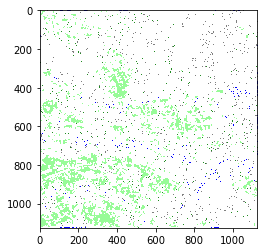

In [55]:
plt.imshow(class_prediction, cmap=cmap)

In [56]:
class_prediction

array([[10, 10, 10, ..., 10, 10, 10],
       [10, 20, 20, ..., 20, 20, 10],
       [10, 20, 20, ..., 40, 40, 10],
       ...,
       [10, 80, 80, ..., 80, 80, 10],
       [10, 80, 80, ..., 80, 80, 10],
       [10, 10, 10, ..., 10, 10, 10]], dtype=uint8)